## Importing Libraries

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/rutviklathiyateksun/acne-grading-classificationdataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahsanatiq98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rutviklathiyateksun/acne-grading-classificationdataset


100%|██████████| 49.0M/49.0M [00:00<00:00, 1.68GB/s]

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomTranslation

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image


### Renaming Target Class Variables

In [ ]:
os.rename("/content/acne-grading-classificationdataset/Created Dataset/Level_0", "/content/acne-grading-classificationdataset/Created Dataset/Mild")
os.rename("/content/acne-grading-classificationdataset/Created Dataset/Level_1", "/content/acne-grading-classificationdataset/Created Dataset/Medium")
os.rename("/content/acne-grading-classificationdataset/Created Dataset/Level_2", "/content/acne-grading-classificationdataset/Created Dataset/Severe")

### Displaing Sample Images

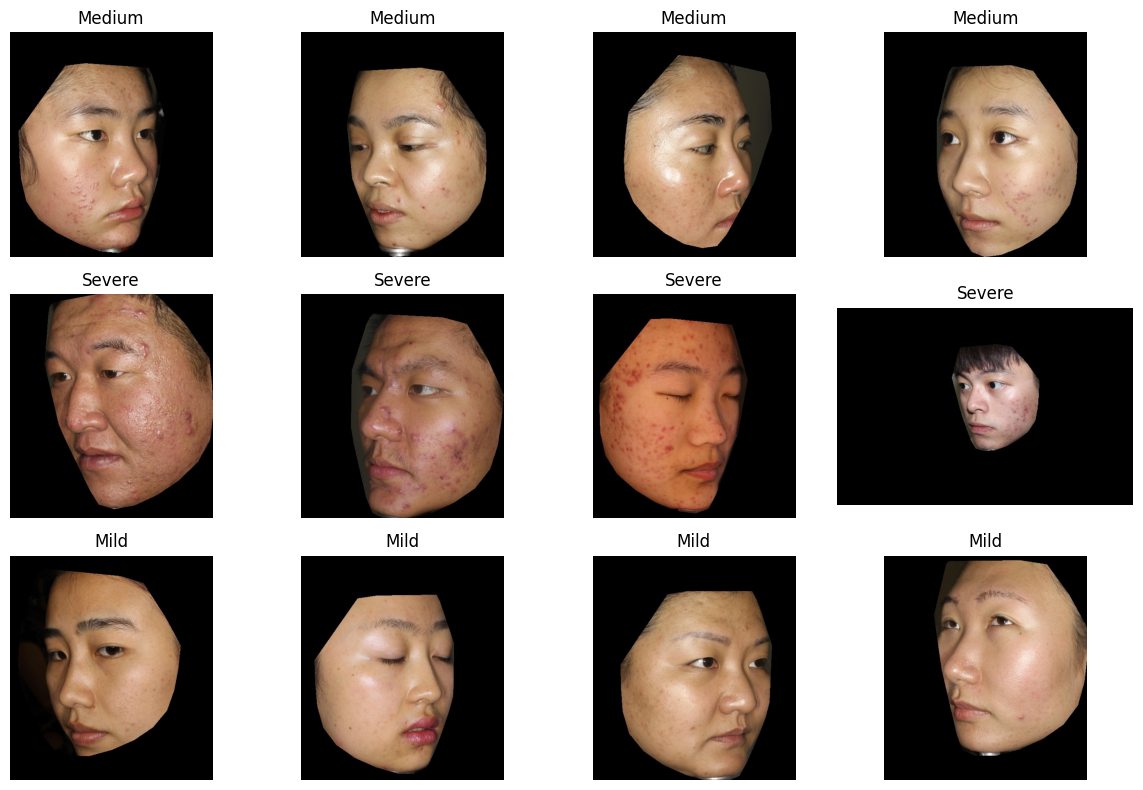

In [ ]:
path = "/content/acne-grading-classificationdataset/Created Dataset"
count = 1
classes = os.listdir(path)

plt.figure(figsize=(12, 8))

for i, j in enumerate(classes):
    class_path = os.path.join(path, j)
    images = os.listdir(class_path)
    sample_images = random.sample(images, min(4, len(images)))

    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(classes), 4, count)
        plt.imshow(img)
        plt.axis("off")
        plt.title(j)
        count += 1

plt.tight_layout()
plt.show()


### Removing Background

In [ ]:
def remove_black(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > 10
    coords = np.argwhere(mask)
    if coords.size == 0:
        return img
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    cropped = img[y0:y1, x0:x1]
    gray_crop = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    mask_white = gray_crop <= 10
    cropped[mask_white] = [255, 255, 255]
    return cropped


In [ ]:
input_root = "/content/acne-grading-classificationdataset/Created Dataset"
output_root = "/content/acne-grading-classificationdataset/Processed"
os.makedirs(output_root, exist_ok=True)

for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    output_class = os.path.join(output_root, class_name)
    os.makedirs(output_class, exist_ok=True)

    for fname in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img = cv2.imread(os.path.join(class_path, fname))
        if img is None:
            continue
        processed = remove_black(img)
        cv2.imwrite(os.path.join(output_class, fname), processed)

Processing Mild: 100%|██████████| 387/387 [00:02<00:00, 138.54it/s]


### Displaying Processed Images

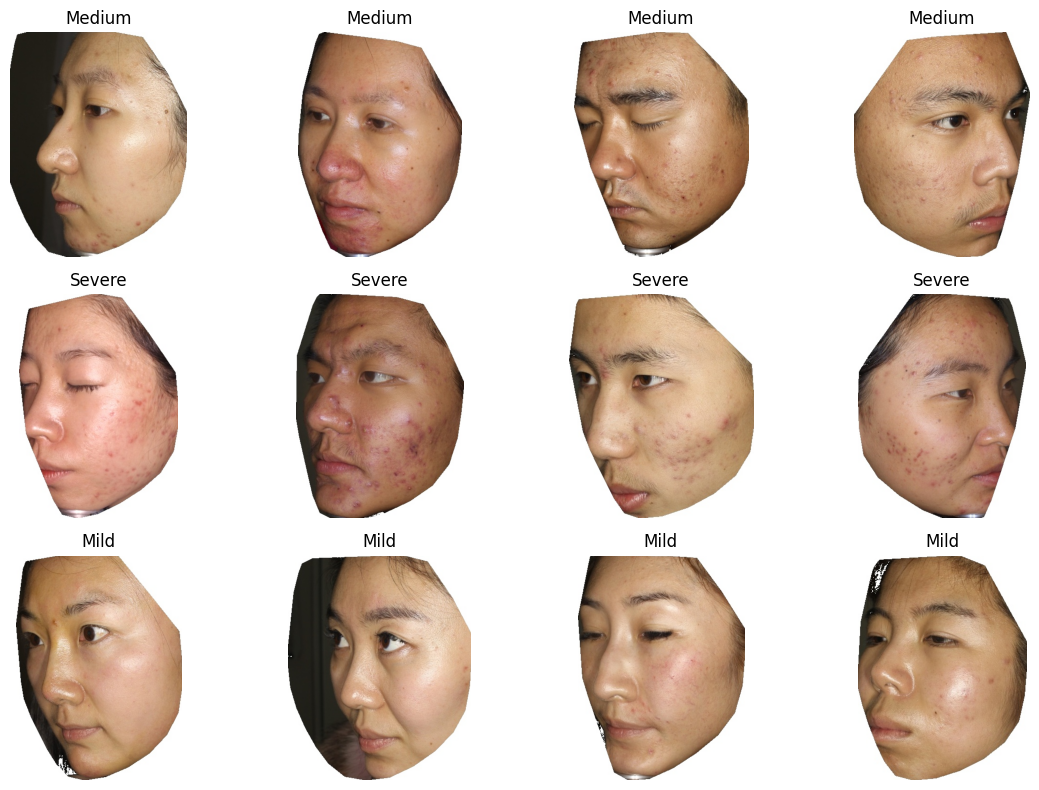

In [ ]:
path = "/content/acne-grading-classificationdataset/Processed"
count = 1
classes = os.listdir(path)

plt.figure(figsize=(12, 8))

for i, j in enumerate(classes):
    class_path = os.path.join(path, j)
    images = os.listdir(class_path)
    sample_images = random.sample(images, min(4, len(images)))

    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(classes), 4, count)
        plt.imshow(img)
        plt.axis("off")
        plt.title(j)
        count += 1

plt.tight_layout()
plt.show()


### Augmenting Images to 30k

In [ ]:
data_augmentation_layer = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.1, 0.1)
])

def augment_image_with_layer(img):
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    augmented_img_tensor = data_augmentation_layer(tf.expand_dims(img_tensor, 0), training=True)
    return tf.squeeze(augmented_img_tensor, 0)


path = "/content/acne-grading-classificationdataset/Processed"
target_image_count = 10000


for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]
    current_count = len(images)

    if current_count >= target_image_count:
        print(f" {class_name} already has {current_count} images.")
        continue

    needed_count = target_image_count - current_count
    print(f" Augmenting class '{class_name}' | Current: {current_count}, Target: {target_image_count}, Need: {needed_count}")

    for i in tqdm(range(needed_count), desc=f"Augmenting {class_name}"):
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        augmented_img_tensor = augment_image_with_layer(img)
        augmented_img = tf.cast(augmented_img_tensor, dtype=tf.uint8).numpy()
        augmented_img = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)

        new_img_name = f"augmented_{i}_{img_name}"
        new_img_path = os.path.join(class_path, new_img_name)
        cv2.imwrite(new_img_path, augmented_img)


🧠 Augmenting class 'Medium' | Current: 473, Target: 10000, Need: 9527


Augmenting Medium: 100%|██████████| 9527/9527 [06:46<00:00, 23.45it/s]


🧠 Augmenting class 'Severe' | Current: 139, Target: 10000, Need: 9861


Augmenting Severe: 100%|██████████| 9861/9861 [06:54<00:00, 23.81it/s]


🧠 Augmenting class 'Mild' | Current: 387, Target: 10000, Need: 9613


Augmenting Mild: 100%|██████████| 9613/9613 [06:46<00:00, 23.63it/s]


### Loading Train and Validation Testing

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/acne_project/acne-grading-classificationdataset/Processed",
    validation_split = 0.2,
    subset = "training",
    seed =123,
    image_size = (224, 224),
    batch_size= 32
)

Found 30000 files belonging to 3 classes.
Using 24000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/acne_project/acne-grading-classificationdataset/Processed",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (224,224),
    batch_size = 32
)

Found 30000 files belonging to 3 classes.
Using 6000 files for validation.


In [ ]:
path = "/content/acne-grading-classificationdataset/Processed"

for cls in os.listdir(path):
  folder = os.path.join(path, cls)
  for f in tqdm(os.listdir(folder)):
    img_path = os.path.join(folder, f)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
      print("corrumpt")
      continue
    if img.ndim != 3  or img.shape[-1] != 3:
      print("Not rgb")

100%|██████████| 10000/10000 [00:10<00:00, 968.70it/s]


### Loading Trained Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/model.keras")

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 2,215,059 (8.45 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

In [ ]:
last = model.layers[-1]
print("Layer:", last.name)

for i, w in enumerate(last.get_weights()):
    print(f"Weights {i} → shape {w.shape}, mean={np.mean(w):.5f}, std={np.std(w):.5f}")

Layer: dense_1
Weights 0 → shape (128, 3), mean=-0.00797, std=0.17410
Weights 1 → shape (3,), mean=-0.00881, std=0.09533


### Calculating on Test Data

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {val_acc:.3f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1590s 8s/step - accuracy: 0.9405 - loss: 0.1499
✅ Final Validation Accuracy: 0.943


### Testing images form Internet

In [ ]:
test_dir = "/content/drive/MyDrive/acne_project/Testers"
processed_dir = "/content/drive/MyDrive/acne_project/Processed_testers"
os.makedirs(processed_dir, exist_ok=True)

for fname in os.listdir(test_dir):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img = cv2.imread(os.path.join(test_dir, fname))
    if img is not None:
        processed = remove_black(img)
        cv2.imwrite(os.path.join(processed_dir, fname), processed)

class_labels = ['Medium', 'Mild', 'Severe']

for filename in os.listdir(processed_dir):
    img = image.load_img(os.path.join(processed_dir, filename), target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img), axis=0)
    preds = model.predict(img_array)
    print(f"{filename}: {class_labels[np.argmax(preds)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
mild.jpg: Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
moderate.jpg: Medium
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
severe.jpg: Severe
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
mild 2.jpg: Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
moderate 2.jpg: Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
mild 3.jpg: Mild
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
severe 3.jpg: Severe
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
severe 2.jpg: Severe
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
moderate 3.jpg: Medium
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
mild 4.jpg: Mild


In [ ]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.4 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok opencv-python-headless pillow tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.8 MB/s eta 0:00:00


In [ ]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 4s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [ ]:
get_ipython().system_raw('streamlit run app.py &')
!lt --port 8501


your url is: https://every-places-hope.loca.lt
^C


In [ ]:
streamlit run app.py


SyntaxError: invalid syntax (ipython-input-507122745.py, line 1)

In [ ]:
# Install dependencies
!pip install tensorflow opencv-python-headless pillow gradio

# -------------------------------
# Imports
# -------------------------------
import gradio as gr
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# Load model (hardcoded path)
# -------------------------------
model_path = "/content/model.keras"  # adjust if needed
model = load_model(model_path, compile=False)

# -------------------------------
# Preprocessing function to remove black borders
# -------------------------------
def remove_black(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > 10
    coords = np.argwhere(mask)
    if coords.size == 0:
        return img
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    cropped = img[y0:y1, x0:x1]
    gray_crop = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    mask_white = gray_crop <= 10
    cropped[mask_white] = [255, 255, 255]
    return cropped

# -------------------------------
# Preprocess image for the model
# -------------------------------
def preprocess_image(image: np.ndarray, target_size=(224,224)):
    # Apply remove_black first
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert to BGR for remove_black
    processed_img_bgr = remove_black(img_bgr)
    processed_img_rgb = cv2.cvtColor(processed_img_bgr, cv2.COLOR_BGR2RGB) # Convert back to RGB

    # Resize and preprocess for the model
    resized_img = cv2.resize(processed_img_rgb, target_size)
    img_float = preprocess_input(resized_img.astype(np.float32))
    return img_float

# -------------------------------
# Prediction function
# -------------------------------
def predict_severity(image):
    img_float = preprocess_image(image)
    img_tensor = np.expand_dims(img_float, axis=0)
    preds = model.predict(img_tensor, verbose=0)
    labels = ['Mild', 'Medium', 'Severe']
    idx = np.argmax(preds[0])
    label = labels[idx]
    confidence = preds[0][idx] * 100
    return f"Predicted Severity: {label} ({confidence:.1f}%)"

# -------------------------------
# Gradio Interface
# -------------------------------
iface = gr.Interface(
    fn=predict_severity,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="🔬 Acne Severity Classifier",
    description="Upload a facial image to classify acne severity."
)

iface.launch(inline=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://473632e908772fd8dd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
